In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

In [2]:
kq3_data = pd.read_excel('data/UF CER KQ3 Data for Analysis.xlsx', sheetname='5.UFKQ3Data', 
                         na_values=['NR', 'NA'],
                        index_col=0)[['Author', 'Year', 'Design', 'Procedure', 'Indication',
                                     'Age, Mean', 'Age, SD', 'Age, Median', 'Age, Min', 'Age, Max', 'Age, Other',
                                     'LMS','Population','Tumors','InPritts']].dropna(thresh=7)
kq3_data.head()

,Author,Year,Design,Procedure,Indication,"Age, Mean","Age, SD","Age, Median","Age, Min","Age, Max","Age, Other",LMS,Population,Tumors,InPritts
Line,,,,,,,,,,,,,,,
1,"Adelusola KA, Ogunniyi SO",2001,Retrospective,NE,NE,NaN,NaN,NaN,19,89,NaN,0,177,0,1
2,"Ahmed AA, Stachurski J, Abdel Aziz E et al",2002,Prospective,NE,NE,NaN,NaN,NaN,29,65,NaN,0,10,0,1
3,"Angle HS, Cohen SM, Hidlebaugh D",1995,Retrospective,NE,NE,41.0,NaN,NaN,24,81,NaN,0,41,0,1
4,"Banaczek Z, Sikora K, Lewandowska-Andruszuk I",2004,Retrospective,NE,NE,44.5,NaN,NaN,29,73,NaN,0,309,0,1
5,"Barbieri R, Dilena M, Chumas J, Rein MS, Fried...",1993,RCT,NE,NE,33.7,NaN,NaN,NaN,NaN,36.3,0,20,0,1


In [3]:
kq3_data.Design.value_counts()

Retrospective       83
Prospective         38
RCT                 26
Pop based cohort     1
Name: Design, dtype: int64

In [17]:
import theano.tensor as tt

model_data = kq3_data

k = model_data.shape[0]
tumors = model_data.Tumors.values.astype(int)
n = model_data.Population.values.astype(int)

def invlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

with pm.Model() as pritts_update:
    
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    π = pm.Deterministic('π', invlogit(θ))
    
    p_update = pm.Deterministic('p_update', invlogit(μ))
    
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)

Applied interval-transform to σ and added transformed σ_interval to model.


In [18]:
with pritts_update:
    step = pm.NUTS()
    trace = pm.sample(2000, step=step, njobs=2)

 [-----------------100%-----------------] 2000 of 2000 complete in 201.7 sec

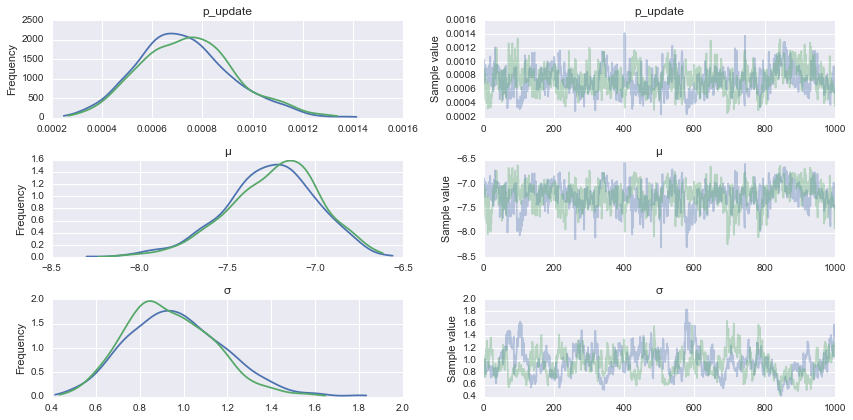

In [30]:
pm.traceplot(trace[1000:], varnames=['p_update', 'μ', 'σ']);

In [28]:
pm.summary(trace[1000:], varnames=['p_update', 'μ', 'σ'], roundto=4)


p_update:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.0007           0.0002           0.0000           [0.0004, 0.0012]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.0004         0.0006         0.0007         0.0009         0.0011


μ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -7.2469          0.2654           0.0157           [-7.7645, -6.7529]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -7.8378        -7.4113        -7.2242        -7.0659        -6.7757


σ:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


By comparison, estimates from Pritts' supplement:

![pritts estimates](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2016-03-28-23-41-27.png)

### Goodness of fit

In [21]:
ppc = pm.sample_ppc(trace, model=pritts_update, samples=500)

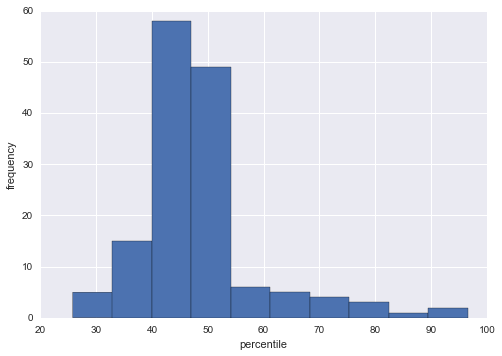

In [25]:
from scipy.stats import percentileofscore
        
p = [percentileofscore(s, o).round(2) for s,o in zip(ppc['obs'].T, tumors)]
        
plt.hist(p)
plt.xlabel('percentile')
plt.ylabel('frequency');